In [16]:
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import json
import os

In [17]:
# !put seed here, because I want nn.Sequential and others like train_loader and sample_generator to
# produce the same init/sample at each run, so that I can find the problem and solve it
# torch.manual_seed(20010302)
device = torch.device("cpu")
# print(device)

In [18]:
input_size = 100
hidden_1 = 60
hidden_2 = 30
output_size = 15

# Create the MLP model using nn.Sequential
MLP = nn.Sequential(
    nn.Linear(input_size, 100),
    nn.ReLU(),
    nn.Linear(100, 15)
    # nn.Sigmoid()
    # nn.LeakyReLU()
    # nn.ReLU(),
    # nn.Linear(hidden_1, hidden_2),
    # nn.ReLU(),
    # nn.Linear(hidden_2, output_size)
).to(device)

# A specific loss function for a concrete problem
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
    
    def forward(self, y_pred, y_label):
        y_pred = torch.max(y_pred, torch.ones_like(y_pred)) ** 2
        y_label = torch.max(y_label, torch.ones_like(y_label)) ** 2
        loss = torch.mean(y_label/y_pred + y_pred/y_label)
        return loss

In [19]:
# Define training model
def train(model, criterion, optimizer, train_loader, number_epochs):
    # print(list(MLP.parameters()))
    loss_list = []

    for epoch in range(number_epochs):
        loss_run = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # params = list(model.parameters())
            # print(f'Params: {params}')
            # forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # backward + optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and accuracy record
            loss_run += loss.item()

        loss_run /= len(train_loader)
        loss_list.append(loss_run)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{number_epochs}], Loss: {loss_run:.4f}')

    # draw the curves
    plt.semilogy(loss_list)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

In [20]:
# make train_loader & test_loader 
with open('data.json', 'r') as f:
    data_raw = json.load(f)
    
x_raw = torch.tensor([[int(i) for i in k.split()] for k in data_raw.keys()], dtype=torch.float)
y_raw = torch.tensor(list(data_raw.values()), dtype=torch.float)
dataset = data.TensorDataset(x_raw, y_raw)
train_dataset, test_dataset = data.random_split(dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)])
train_loader = data.DataLoader(train_dataset, batch_size=int(len(train_dataset)), shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=True)

Epoch [100/10000], Loss: 5649119481692160.0000
Epoch [200/10000], Loss: 4302678372909056.0000
Epoch [300/10000], Loss: 3524577133068288.0000
Epoch [400/10000], Loss: 2999636029603840.0000
Epoch [500/10000], Loss: 2617022894571520.0000
Epoch [600/10000], Loss: 2316702138236928.0000
Epoch [700/10000], Loss: 2075009832976384.0000
Epoch [800/10000], Loss: 1876495773466624.0000
Epoch [900/10000], Loss: 1707955619627008.0000
Epoch [1000/10000], Loss: 1563045436325888.0000
Epoch [1100/10000], Loss: 1438173020291072.0000
Epoch [1200/10000], Loss: 1329689662586880.0000
Epoch [1300/10000], Loss: 1233156514512896.0000
Epoch [1400/10000], Loss: 1146953702309888.0000
Epoch [1500/10000], Loss: 1071087131557888.0000
Epoch [1600/10000], Loss: 1003463274135552.0000
Epoch [1700/10000], Loss: 942246165741568.0000
Epoch [1800/10000], Loss: 887548280832000.0000
Epoch [1900/10000], Loss: 838280643870720.0000
Epoch [2000/10000], Loss: 793174092021760.0000
Epoch [2100/10000], Loss: 752131451650048.0000
Epoch 

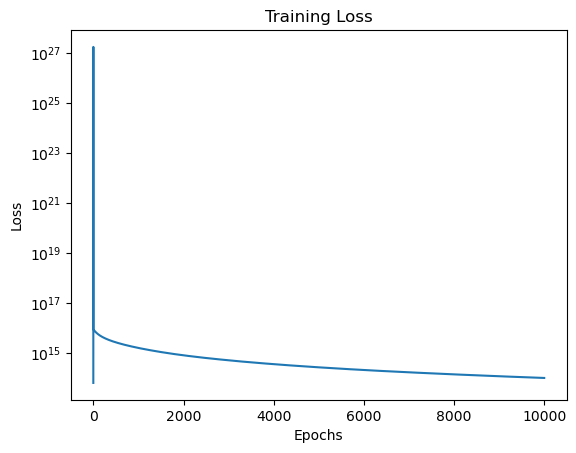

In [21]:
# train the model
learning_rate = 1e-5
# for Adam, it needs 1500, and after 1500 it will be overfit and loss will increase. the learning rate should be 1 or more
# but for SGD, it will use tens of epochs. learning rate should be 0.00001 or always get inf loss
num_epochs = 10000
# criterion = nn.MSELoss().to(device)
criterion = CustomLoss().to(device)

optimizer = optim.Adam(MLP.parameters(), lr=100, betas=(0.9, 0.999))
# optimizer = optim.SGD(MLP.parameters(), learning_rate)

# print(next(MLP.parameters()).device)

train(MLP, criterion, optimizer, train_loader, num_epochs)

In [22]:
os.system('truncate -s 0 predicts.output')
q_errors = [(0,0)]*output_size
for inputs, labels in test_loader:
    outputs = MLP(inputs)
    # loss = criterion(outputs, labels)
    outputs = [max(1, round(float(i))) for i in outputs[0]]
    q_error = [float(max(outputs[i]/labels[0][i], labels[0][i]/outputs[i])) for i in range(len(outputs))]
    q_error = [0 if math.isnan(e) else round(e, 2) for e in q_error]
    with open('predicts.output', 'a') as outfile:
        outfile.write(str(q_error)+'\n')
    q_errors = [(round(q_errors[i][0]+q_error[i],  2), q_errors[i][1]+1) if math.isinf(q_error[i])==False else q_errors[i] for i in range(output_size)]
print(q_errors)
print([round(t[0]/t[1], 2) for t in q_errors])

[(633180965.67, 2262), (113642160.33, 2249), (53292579.0, 2242), (3384567.0, 2101), (15867378592.92, 2262), (5039070535.99, 2249), (2000151.77, 2249), (551729918.21, 2242), (528255291.0, 2101), (118346386.45, 2215), (1315102483.49, 2226), (321220603.0, 2101), (80295609.0, 2096), (33871505.0, 1937), (1223940.0, 1508)]
[279920.85, 50530.08, 23770.11, 1610.93, 7014756.23, 2240582.72, 889.35, 246088.28, 251430.41, 53429.52, 590791.77, 152889.39, 38308.97, 17486.58, 811.63]
